In [1]:
import sys
import numpy as np
import torch
import time

In [2]:
from torch.utils.data import DataLoader
from utils import load_model
from problems import MTSP, TSP

In [16]:
from matplotlib import pyplot as plt
# my files
sys.path.insert(0, '~/dev/Thesis/MixedIntegerOptimization/')
from offlineOptimizationProblem_unlimited_time import run_mtsp_opt, analysis_and_plot_results

In [17]:
def discrete_cmap(N, base_cmap=None):
    """
    Create an N-bin discrete colormap from the specified input map
    """
    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    return plt.cm.get_cmap(base_cmap, N)

In [18]:
def plot_vehicle_routes(data, route, ax1, markersize=5):
    """
    Plot the vehicle routes on matplotlib axis ax1.
    """
    depot_marker = '*'
    regular_marker = 's'
    n_cars, tour_length = route.shape
    loc = torch.cat((data['depot'][None, :], data['loc']), -2)
    n_nodes = loc.shape[0]
    cmap = discrete_cmap(n_cars)
    for i_c in range(n_cars):
        route_ = route[i_c, :]
        d = loc.gather(0, route_.unsqueeze(-1).expand(tour_length, 2).type(torch.long))
        marker=depot_marker
        ax1.scatter(loc[0, 0], loc[0, 1], color=cmap(i_c), marker=marker)
        ax1.text(loc[0, 0], loc[0, 1], 'depot')
        ax1.plot([loc[0, 0], d[0, 0]], [loc[0, 1], d[0, 1]], color=cmap(i_c))
        for j in range(d.shape[0]):
            if j == 0:
                marker = regular_marker
                ax1.scatter([], [], color=cmap(i_c), label='car id:'+str(i_c))
            else:
                marker = regular_marker
            ax1.text(d[j, 0], d[j, 1], str(route_[j].item()))
            ax1.scatter(d[j, 0], d[j, 1], color=cmap(i_c), marker=marker)
            if j+1 < d.shape[0]:
                ax1.plot([d[j, 0], d[j+1, 0]], [d[j, 1], d[j+1, 1]], color=cmap(i_c))
        if route_[-1] != 0:
            ax1.plot([d[-1, 0], loc[0, 0]], [d[-1, 1], loc[0, 1]], color=cmap(i_c))

In [19]:
def plot_opt_results(adj_mat, loc, ax1):
    data_plot = {'loc': torch.tensor(loc[1:, :]),
                 'depot': torch.tensor(loc[0, :])}
    mat_indexs = np.where(adj_mat[:, 0] > 0)[0]
    car_loc = loc[mat_indexs]
    n_cars = car_loc.shape[0]
    n_nodes = loc.shape[0]
    car_route = np.zeros([n_cars, n_nodes])
    car_route[:, 0] = mat_indexs
    for i, index in enumerate(mat_indexs):
        next_node = np.where(adj_mat[:, index] > 0)[0]
        car_route[i, 1] = next_node[0]
        j = 2
        while(next_node != 0):
            next_node = np.where(adj_mat[:, next_node] > 0)[0]
            car_route[i, j] = next_node
            j += 1
    plot_vehicle_routes(data_plot, torch.tensor(car_route), ax1, markersize=5)

In [20]:
figures_loc = './figures/'
problem_loc = './outputs/mtsp_10/'
model_loc = []
seed = 1234
torch.manual_seed(seed)

In [21]:
# ********************************** grid : 10 ********************************** #
# model_loc.append('mtsp10_without_repeated_20200106T163908/epoch-22.pt')
# model_loc.append('mtsp10_no_repeated_20200106T212507/epoch-141.pt')
# model_loc.append('mtsp10_no_repeated_20200108T121907/epoch-225.pt')
model_loc.append('mtsp10_without_repeated_20200108T172503/epoch-349.pt')

#  ********************************** grid : 12 ********************************** #
# model_loc.append('mtsp12_cars3_no_repeated_20200108T110053/epoch-200.pt')
# model_loc.append('mtsp12_cars3_no_repeated_20200108T110053/epoch-399.pt')

# ********************************** grid : 20 ********************************** #
# model_loc.append('mtsp20_no_repeated_20200110T101020/epoch-407.pt')

In [22]:
n_samples = 3
cmap2 = discrete_cmap(len(model_loc) + 1)
cost_models = np.zeros([len(model_loc), n_samples])

multi_attention
  [*] Loading model from ./outputs/mtsp_10/mtsp10_without_repeated_20200108T172503/epoch-349.pt
***************************************************
mtsp10_without_repeated_20200108T172503/epoch-349.pt:
model run time:0.017244815826416016
average length is:tensor(3.9470)
max length is: tensor(4.8853)
mean length is:tensor(2.8627)
std length is: tensor(1.0192)


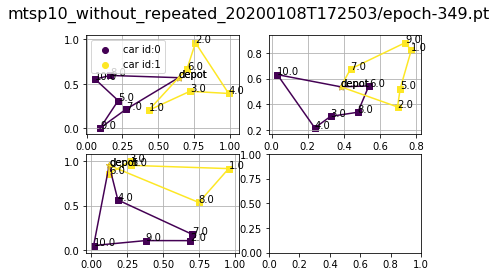

In [26]:
flag_plot_results = True
for i_m in range(len(model_loc)):
        # load model from file - 
        model, _ = load_model(problem_loc + model_loc[i_m])
        # create dataset based on first model , then use the same nodes for all models to be checked
        if i_m == 0:  
            dataset = MTSP.make_dataset(size=model.n_nodes - 1, num_samples=n_samples, n_cars=model.n_cars)
            # Need a dataloader to batch instances
            dataloader = DataLoader(dataset, batch_size=1000)
            # Make var works for dicts
            batch_data = next(iter(dataloader))
        # create title for figure, based on model name
        fig_title = model_loc[i_m]
        # Run the model
        model.eval()
        model.set_decode_type('sampling')
        with torch.no_grad():
            # clock model run time
            s_time = time.time()
            length, log_p, pi = model(batch_data, return_pi=True)
            e_time = time.time()
            # log cost of total route from model 
            cost_models[i_m, :] = length.detach().numpy()
            print("***************************************************")
            print(model_loc[i_m] + ":")
            print("model run time:"+str(e_time-s_time))
            # print(length)
            print("average length is:" + str(length.mean()))
            print("max length is: " + str(length.max()))
            print("mean length is:" + str(length.min()))
            print("std length is: " + str(length.std()))
        tours = pi.permute(1, 0, 2)  # new order is [batch_size, n_cars, tour_length]
        n_splots = int(np.ceil(n_samples / 2))
        if flag_plot_results:
            # create figures for plotting routes - 
            fig, ax = plt.subplots(n_splots, 2)
            # Plot the routes model found - 
            for i, (data, tour) in enumerate(zip(dataset, tours)):
                x_p = i // 2
                y_p = i % 2
                plot_vehicle_routes(data, tour, ax[x_p][y_p])
                ax[x_p][y_p].grid()
            fig.suptitle(fig_title, fontsize=16)
            ax[0][0].legend(loc='best')

starting opt num:0
starting opt num:1
starting opt num:2
***************************************************
optimization results:
opt tot time:0.6036791801452637
mean cost is:3.899053805718778
std cost : 0.7791970856002615
max cost is:4.741620981818536


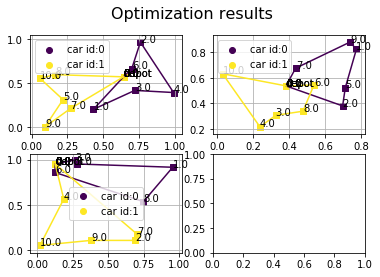

In [27]:
# run optimization for comparison
opt_file_name = 'opt_results_' + str(n_samples) + '_seed' + str(seed)
car_loc = np.random.rand(model.n_cars, 2)
events_batch_loc = batch_data['loc'].detach().numpy()
events_batch_depot = batch_data['depot'].detach().numpy()
opt_cost = np.zeros(n_samples)
if flag_plot_results:
    fig_opt, ax_opt = plt.subplots(n_splots, 2)
opt_time = 0
for i in range(events_batch_loc.shape[0]):
    events_loc = np.row_stack((events_batch_depot[i, ...], events_batch_loc[i, ...]))
    s_time = time.time()
    print("starting opt num:"+str(i))
    m, obj = run_mtsp_opt(car_loc, events_loc)
    e_time = time.time()
    opt_time += e_time-s_time
    # # run analysis and plot results
    data_out = analysis_and_plot_results(m, car_loc, events_loc, False, figures_loc, opt_file_name, 1, False)
    opt_cost[i] = obj.getValue()
    if flag_plot_results:
        x_p = i // 2
        y_p = i % 2
        plot_opt_results(data_out, events_loc, ax_opt[x_p][y_p])
        ax_opt[x_p][y_p].grid()
        ax_opt[x_p][y_p].legend(loc='best')
        fig_opt.suptitle('Optimization results', fontsize=16)
print("***************************************************")
print("optimization results:")
print("opt tot time:"+str(opt_time))
# print("cost:"+str(opt_cost))
print("mean cost is:" + str(np.mean(opt_cost)))
print("std cost : " + str(np.std(opt_cost)))
print("max cost is:" + str(np.max(opt_cost)))


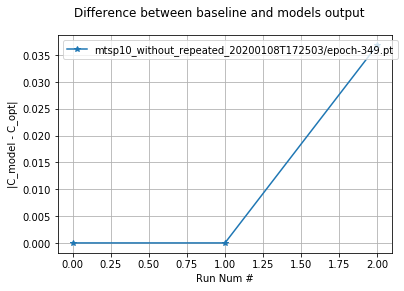

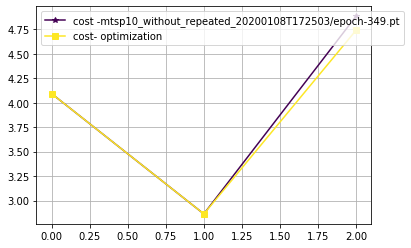

In [28]:
fig_diff, ax_diff = plt.subplots(1, 1)
fig2, ax2 = plt.subplots(1, 1)
for i_m in range(len(model_loc)):
    ax2.plot(range(n_samples), length.detach().numpy(), label='cost -' + model_loc[i_m], marker='*', color=cmap2(i_m))
    ax_diff.plot(range(n_samples), np.abs(opt_cost-cost_models[i_m, :])/np.mean(opt_cost), label=model_loc[i_m], marker='*')
ax2.plot(range(n_samples), opt_cost, label='cost- optimization', marker='s', color=cmap2(i_m + 1))

ax_diff.grid()
ax_diff.set_xlabel('Run Num #')
ax_diff.set_ylabel('|C_model - C_opt|')
fig_diff.suptitle('Difference between baseline and models output')
ax_diff.legend(loc='upper left')

ax2.grid()
ax2.legend(loc='upper left')
# fig.savefig(os.path.join('images', 'cvrp_{}.png'.format(i)))